In [1]:
import os
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
import seaborn as sns
from collections import Counter
from tqdm import tqdm, trange

from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

import catboost as cb

import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
path = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [3]:
df = pd.read_csv(path, index_col=0, low_memory=False)
print(f"There are {df.shape[0]} samples and {df.shape[1]} features in the dataset.")
df.head(5)

There are 7043 samples and 20 features in the dataset.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

## Missing Values

It is worth noting that the data type of `TotalCharges` feature is `object` instead of `float64`. This is because there are some missing values in this feature. We will deal with this later.

In [5]:
df['TotalCharges'] = df.TotalCharges.map(lambda x: float(x) if x != ' ' else np.nan)

In [6]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are 11 samples with missing values in `TotalCharges` feature, with a percentage of $0.16\%$. So we can safely drop these samples.

In [7]:
df.dropna(inplace=True)

## Data Types and Transformations

In [8]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] # 数值型特征
cat_cols = df.columns.drop(num_cols + ['Churn']) # 类别型特征，不包括label
print(f"Numberical features: {num_cols}")
print(f"Categorical features: {cat_cols.tolist()}")

Numberical features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [9]:
binary_cats = [cat for cat in cat_cols if df[cat].nunique() == 2] # 二值类别型特征
multi_cats = cat_cols.drop(binary_cats) # 多值类别型特征
print(f"Binary categorical features: {binary_cats}")
print(f"Multi-value categorical features: {multi_cats.tolist()}")

Binary categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
Multi-value categorical features: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [10]:
ore = OrdinalEncoder()
binary_cat_data = ore.fit_transform(df[binary_cats])
binary_cat_data = pd.DataFrame(binary_cat_data, columns=binary_cats, index=df.index)
binary_cat_data.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
customerID,,,,,,
7590-VHVEG,0.0,0.0,1.0,0.0,0.0,1.0
5575-GNVDE,1.0,0.0,0.0,0.0,1.0,0.0
3668-QPYBK,1.0,0.0,0.0,0.0,1.0,1.0
7795-CFOCW,1.0,0.0,0.0,0.0,0.0,0.0
9237-HQITU,0.0,0.0,0.0,0.0,1.0,1.0


In [11]:
ohe = OneHotEncoder()
multi_cat_data = ohe.fit_transform(df[multi_cats]).toarray()
multi_cat_data = pd.DataFrame(multi_cat_data, columns=ohe.get_feature_names_out(), index=df.index)
multi_cat_data.head(5)

,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5575-GNVDE,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3668-QPYBK,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7795-CFOCW,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9237-HQITU,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
st = StandardScaler()
num_data = st.fit_transform(df[num_cols])
num_data = pd.DataFrame(num_data, columns=num_cols, index=df.index)
num_data.head(5)

,tenure,MonthlyCharges,TotalCharges
customerID,,,
7590-VHVEG,-1.280248,-1.161694,-0.994194
5575-GNVDE,0.064303,-0.260878,-0.173740
3668-QPYBK,-1.239504,-0.363923,-0.959649
7795-CFOCW,0.512486,-0.747850,-0.195248
9237-HQITU,-1.239504,0.196178,-0.940457


In [13]:
X_new = pd.concat([binary_cat_data, multi_cat_data, num_data], axis=1)
X_new.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.280248,-1.161694,-0.994194
5575-GNVDE,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.064303,-0.260878,-0.173740
3668-QPYBK,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.239504,-0.363923,-0.959649
7795-CFOCW,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.512486,-0.747850,-0.195248
9237-HQITU,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.239504,0.196178,-0.940457


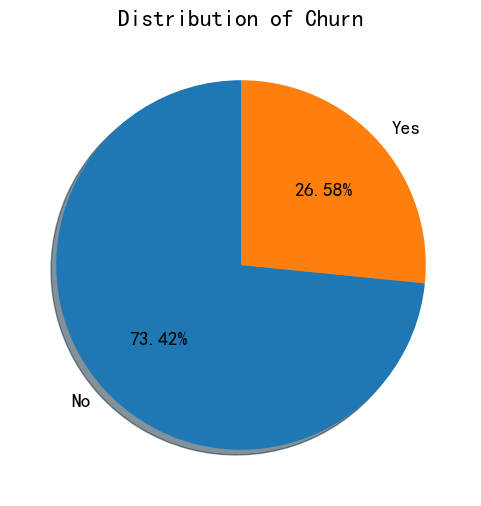

In [14]:
y = df['Churn'].map(lambda x: 1 if x == 'Yes' else 0)
# pie chart
plt.figure(figsize=(6, 6))
plt.pie(y.value_counts(), labels=['No', 'Yes'], autopct='%1.2f%%', shadow=True, startangle=90)
plt.title('Distribution of Churn')
plt.show()

## Feature Selection

### Spearman Correlation

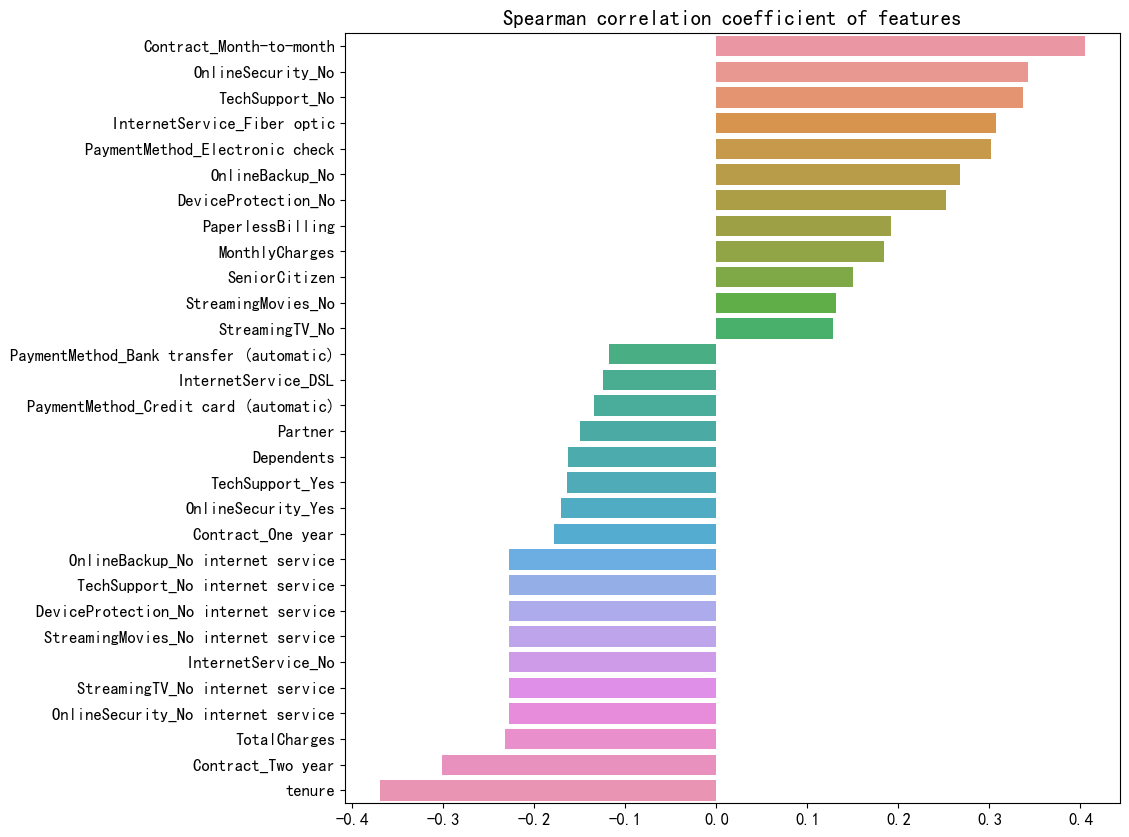

In [15]:
corr = pd.concat([X_new, y], axis=1).corr(method='spearman')
spearman_corr =  corr.Churn.sort_values(ascending=False)[1:]
spearman_corr = spearman_corr[abs(spearman_corr) > 0.1]
plt.figure(figsize=(10, 10))
sns.barplot(x=spearman_corr.values, y=spearman_corr.index)
plt.title("Spearman correlation coefficient of features", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

### Family-wise Error Rate

In [16]:
from sklearn.feature_selection import SelectFwe

In [17]:
selector = SelectFwe()
selector = selector.fit(X_new, y)
selected_features = X_new.columns[selector.get_support()].tolist()
print(f"Optimal number of features: {len(selected_features)}")
print(f"Selected features: {selected_features}")

Optimal number of features: 36
Selected features: ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'TotalCharges']


# Classification

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new[selected_features], y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

Training set: 5625 samples, 36 features
Testing set: 1407 samples, 36 features


In [19]:
res = {}

## Logistic Regression

In [20]:
res['LogisticRegression'] = {}

In [21]:
# before optimization

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
res['LogisticRegression']['base'] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7882018479033405


In [22]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cholesky']
}

lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
lr_grid.fit(X_train, y_train)
print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best cross-validation score: {lr_grid.best_score_}")
y_pred = lr_grid.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
res['LogisticRegression']['optimization'] = accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8071111111111111
Accuracy: 0.7867803837953091


## Decision Tree

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
res['DecisionTreeClassifier'] = {}
res['DecisionTreeClassifier']['base'] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7327647476901208


In [24]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 17, 2),
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
dt_grid.fit(X_train, y_train)
print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best cross-validation score: {dt_grid.best_score_}")
y_pred = dt_grid.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
res['DecisionTreeClassifier']['optimization'] = accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4}
Best cross-validation score: 0.7952
Accuracy: 0.7668798862828714


## XGBoost

In [25]:
import xgboost as xgb

In [26]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
res['XGBClassifier'] = {}
res['XGBClassifier']['base'] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7810945273631841


In [27]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [28]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 200,
        'seed': 0
    }

In [29]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [30]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

SCORE:                                                 
0.7341862117981521                                     
SCORE:                                                 
0.7341862117981521                                                                
SCORE:                                                                            
0.7732764747690121                                                                
SCORE:                                                                            
0.7761194029850746                                                                
SCORE:                                                                            
0.7341862117981521                                                                
SCORE:                                                                            
0.7341862117981521                                                                
SCORE:                                                                            
0.

In [31]:
best_hyperparams

{'colsample_bytree': 0.8376950935418355,
 'gamma': 3.1270020022231906,
 'max_depth': 12.0,
 'min_child_weight': 9.0,
 'reg_alpha': 68.0,
 'reg_lambda': 0.1280604137732796}

In [32]:
model = xgb.XGBClassifier(
    n_estimators =200, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=int(best_hyperparams['colsample_bytree']))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
res['XGBClassifier']['optimization'] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7846481876332623
